In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 95 (delta 48), reused 17 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 26.93 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
!pip install jcopdl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-2.3.3-py2.py3-none-any.whl size=38152 sha256=37b6a4c3f3cf0ade38f6a8587d9f5774c3b710e8e099266a57378b1c5a01e760
  Stored in directory: /root/.cache/pip/wheels/53/6a/44/7fb55b01636e06307f8ae07ad8f1ed6b4b7a25c08ab8097d7c
  Created wheel for pyperclip: filename=pyperclip-1.9.0-py3-none-any.whl size=11002 sha256=a916ca9d7d3936eba962c46ac5f2fb5c376f685a0f515f744e9b0f82dac3d8f6
  Stored in directory: /root/.cache/pip/wheels/cc/ae/36/ee17d1de094fcb61e24106cb329b5103861e819f94bef5e10a
Successfully built jcopdl pyperclip


In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [5]:
batch_size = 64
img_size = 224, 224

train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/penyakit-padi/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/penyakit-padi/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [4]:
feature, labels = next(iter(trainloader))
print(feature.shape)

torch.Size([64, 3, 224, 224])


In [5]:
n1, n2 = max(0, 1 - 0.3), 1 + 0.3
print(n1, n2)

0.7 1.3


In [6]:
label2cat = train_set.classes

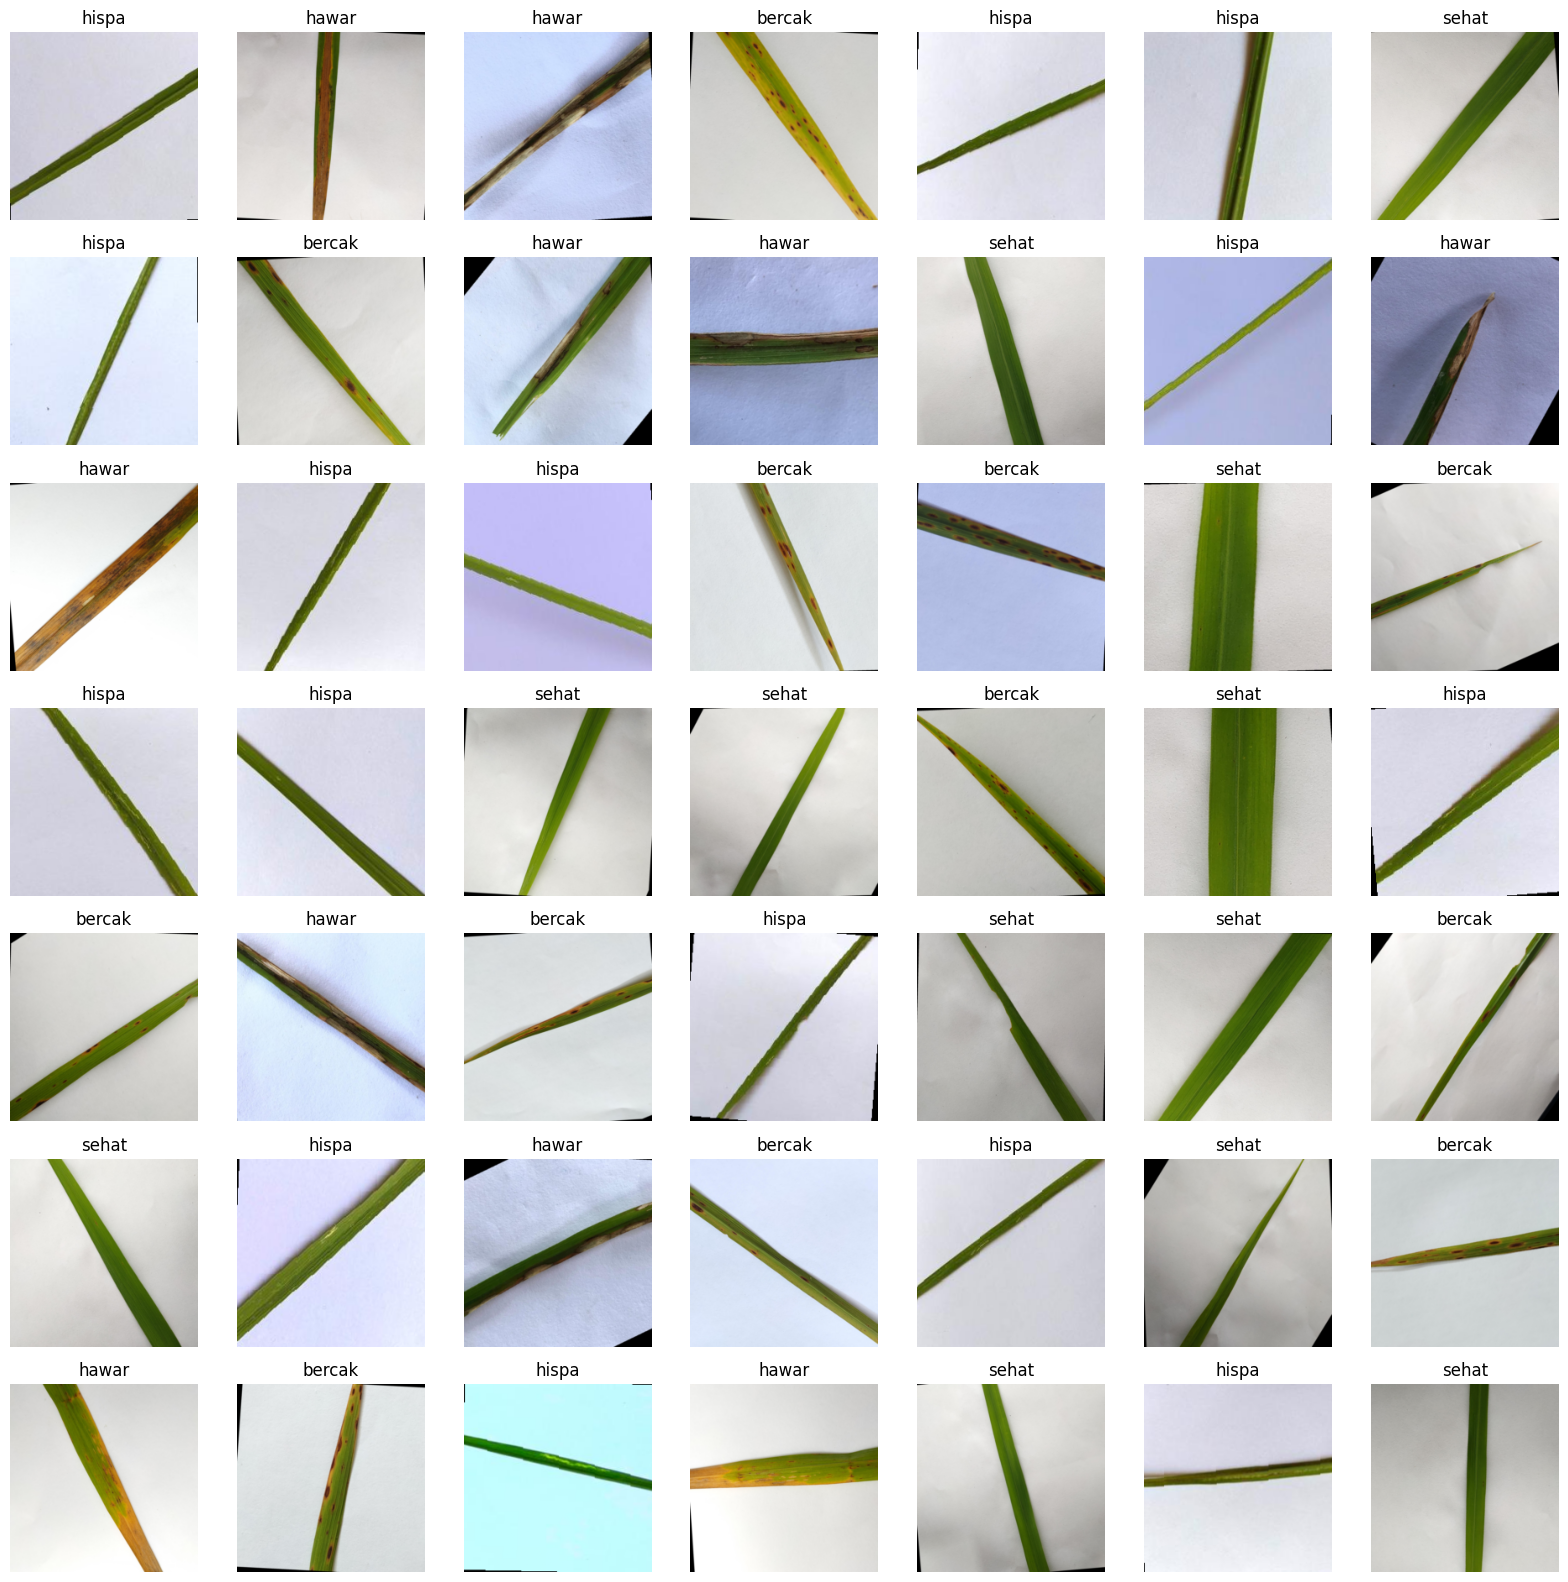

In [9]:
fig, axes = plt.subplots(7, 7, figsize=(20,20))
for img,label, ax in zip(feature,labels, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    ax.set_title(f'{label2cat[label.item()]}')
    ax.axis('off')
plt.savefig('preprocessing.png')

In [10]:
plt.savefig('preprocessing.png')

<Figure size 640x480 with 0 Axes>

In [6]:
from jcopdl.callback import Callback

In [7]:
from tqdm import tqdm

In [8]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [9]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, callback):
    while True:
        model.train()
        train_loss, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_score = loop_fn("val", val_set, valloader, model, criterion, optimizer, device)

        callback.log("train_loss", train_loss)
        callback.log("train_score", train_score)
        callback.log("val_loss", val_loss)
        callback.log("val_score", val_score)
        callback.add_plot(["val_loss","train_loss"])
        callback.add_plot(["val_score","train_score"])
        

        if callback.early_stopping("minimize", monitor="val_loss"):
            break

In [10]:
!git clone https://github.com/januar-png/Model.git

Cloning into 'Model'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 8.20 KiB | 8.20 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [11]:
from Model.CNNpenyakitPadi import CNNpenyakitPadi

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-6)
callback = Callback(model, optimizer,early_stop_patience=5)

Val: 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]


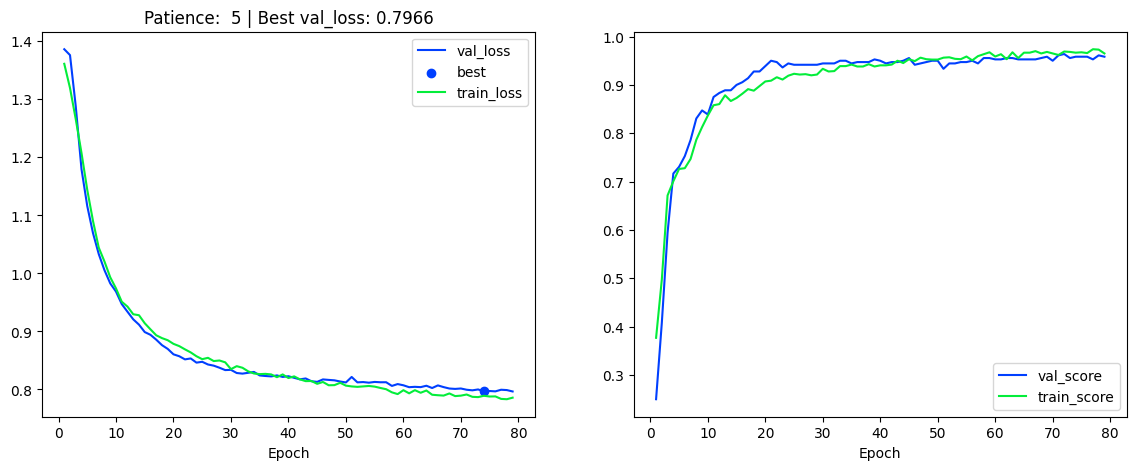

Val: 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


==> Execute Early Stopping at epoch: 79 | Best val_loss: 0.7966
==> Best model is saved at output


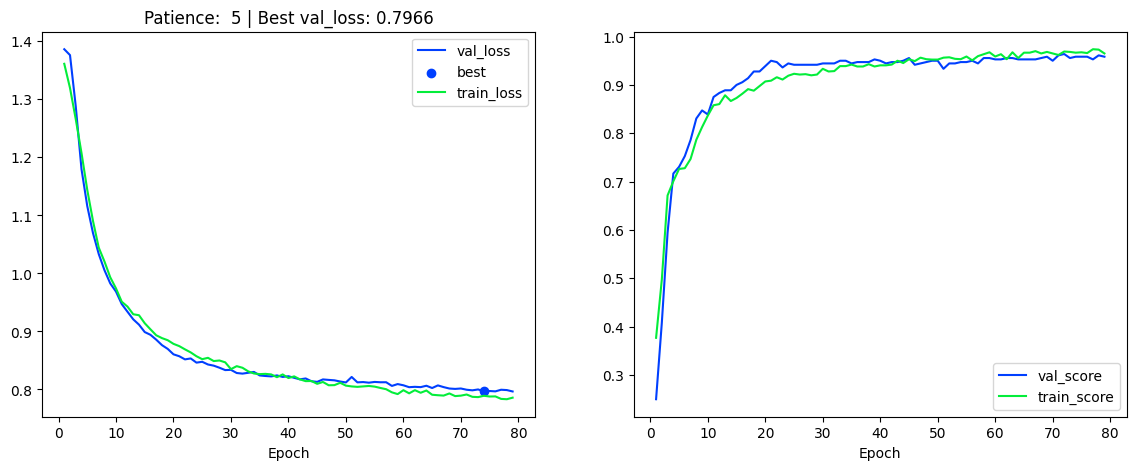

In [13]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, callback)

In [14]:
!pip install torchsummary

In [15]:
45*4

180

In [16]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/penyakit-padi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False, batch_size=180)

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
print(feature.shape)

torch.Size([180, 3, 224, 224])


In [20]:
with torch.no_grad():
    model = torch.load('/kaggle/working/output/model_best.pth')
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

/tmp/ipykernel_30/529029719.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/output/model_best.pth')


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

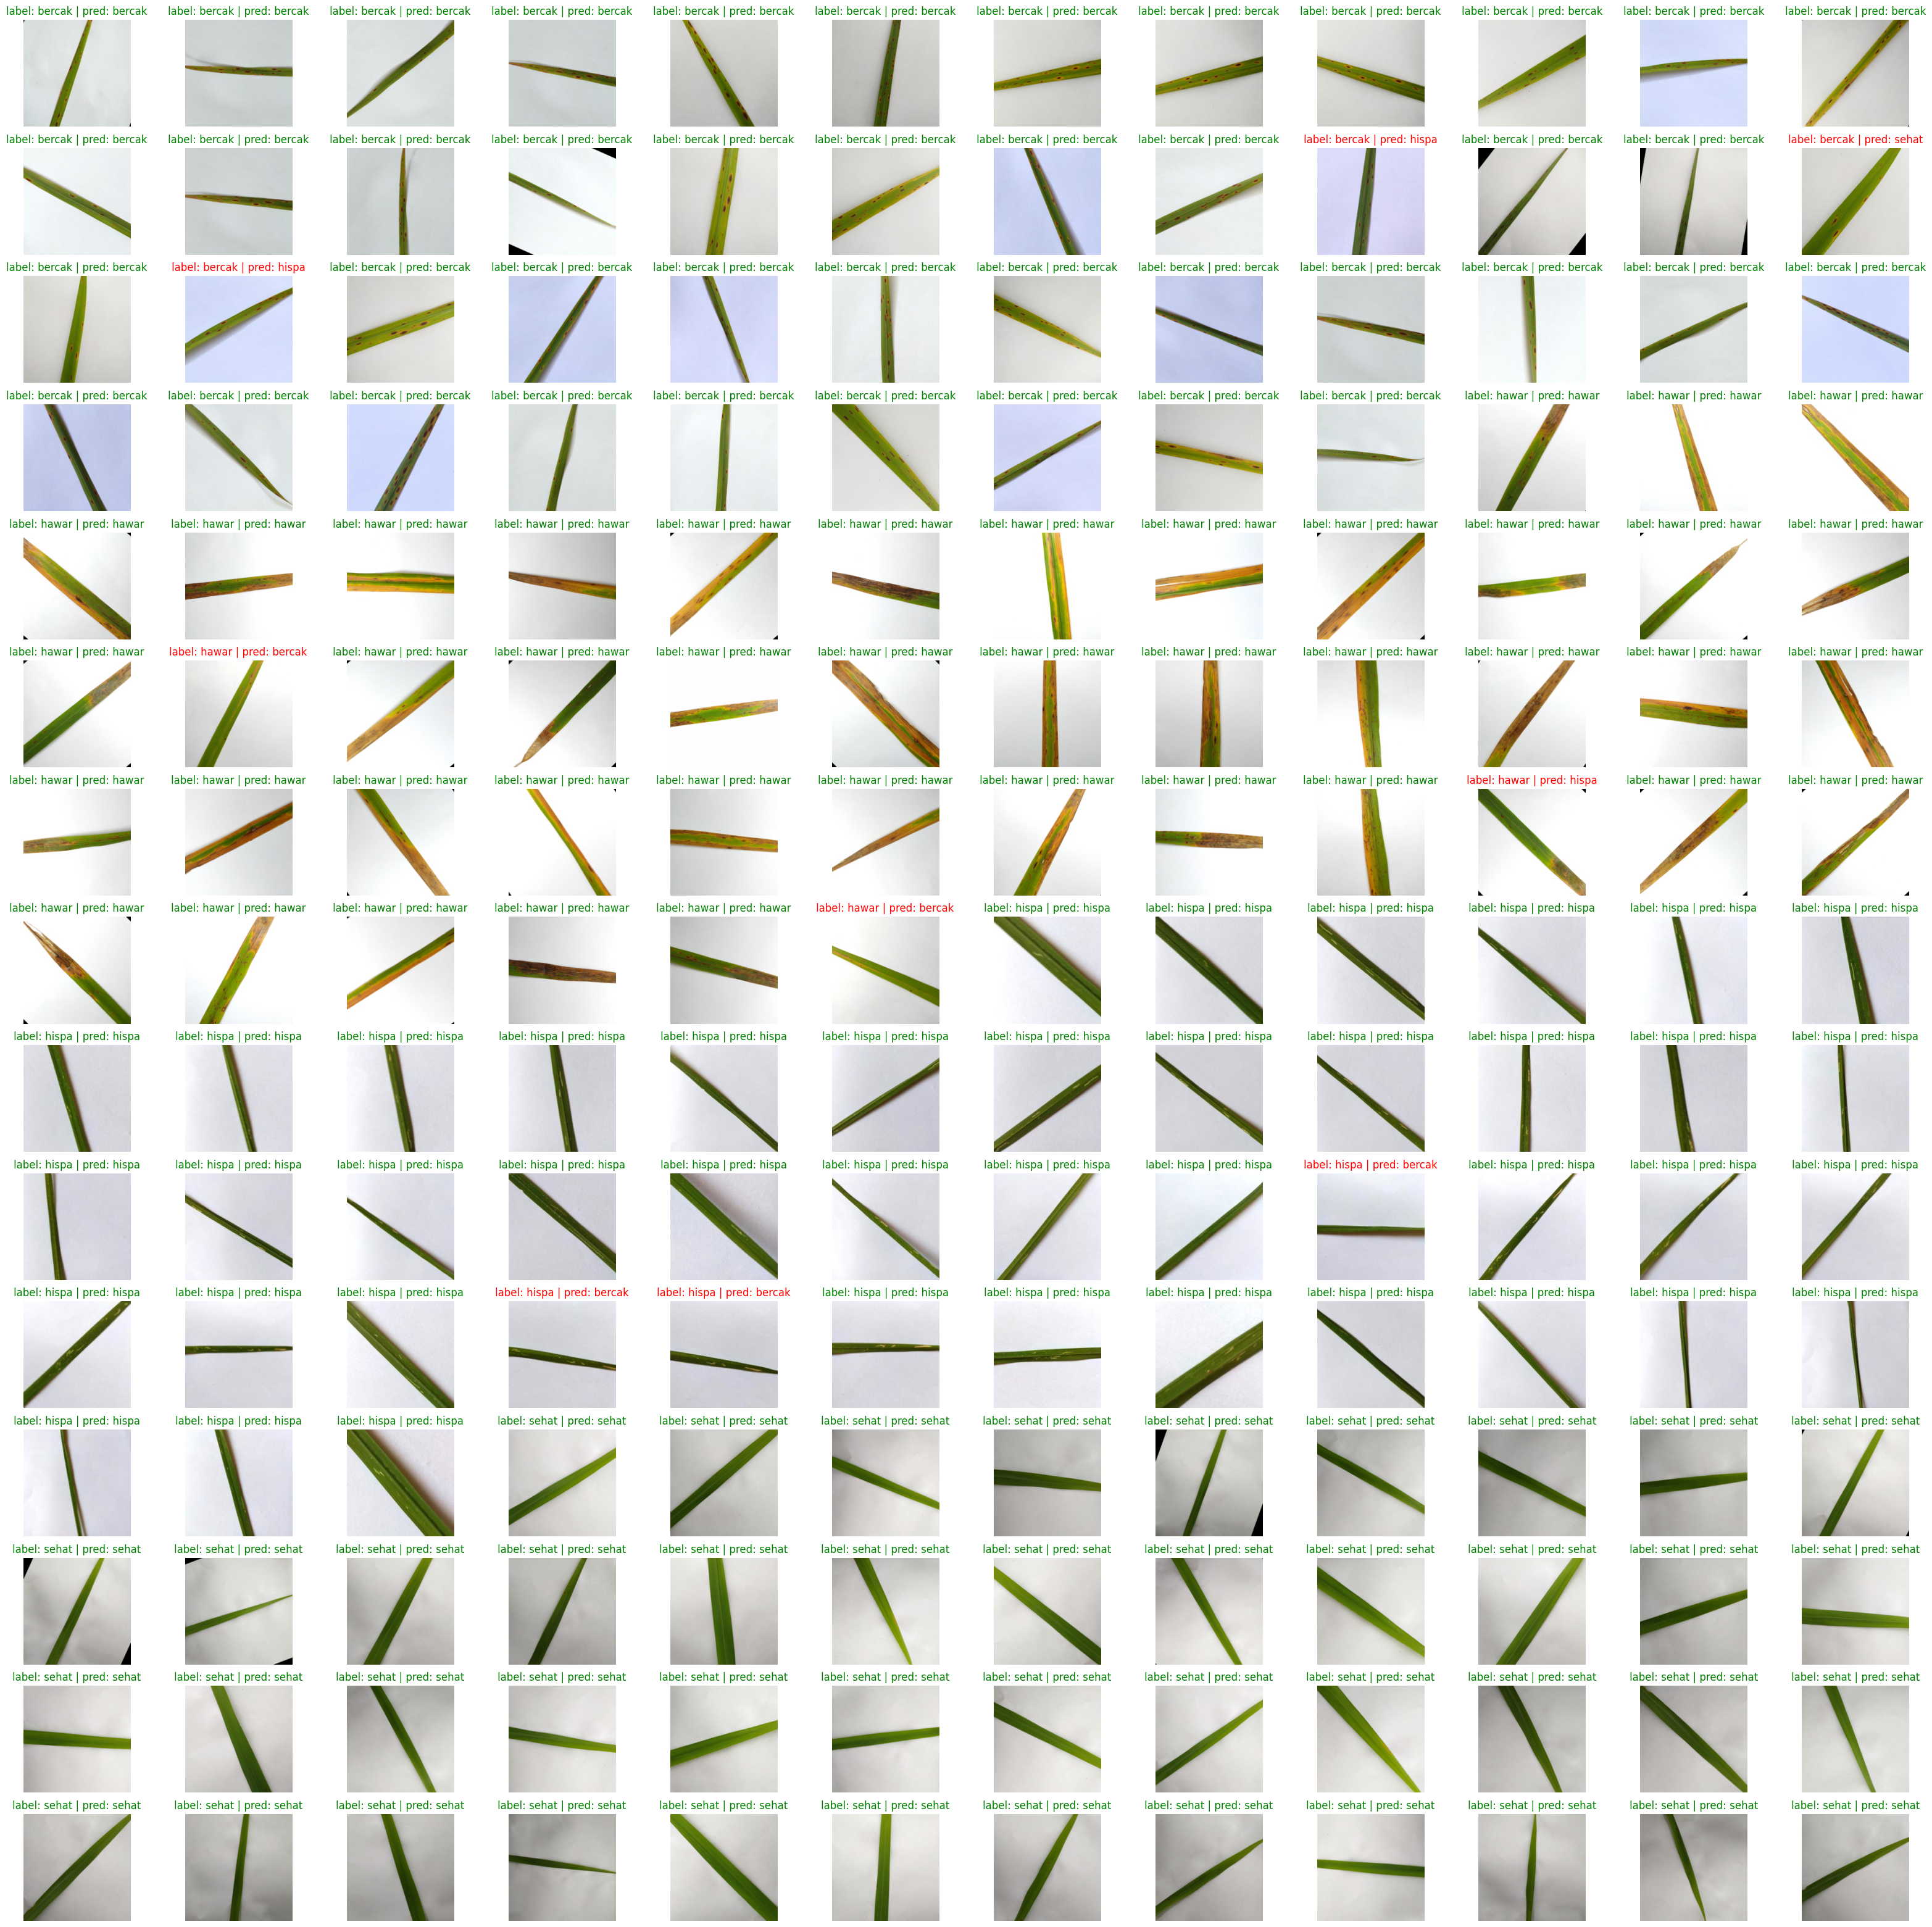

In [21]:
label2cat = train_set.classes

fig, axes = plt.subplots(15,12, figsize=(40,40))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color":'r'} if label.item() != pred.item() else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]  
    ax.set_title(f"label: {label} | pred: {pred}", fontdict=font)
    ax.axis('off')

In [ ]:
180/15

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()

In [28]:
def evaluate_model(model, testloader, criterion, device):
    model = torch.load('/kaggle/working/output/model_best.pth')
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    if not os.path.exists('confusion_matrix'):
        os.makedirs('confusion_matrix')

    plt.savefig(f'confusion_matrix/{model.__class__.__name__}.png')

/tmp/ipykernel_30/173143204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/output/model_best.pth')


Test Loss: 0.8101, Test Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       1.00      0.93      0.97        45
           2       0.93      0.93      0.93        45
           3       0.98      1.00      0.99        45

    accuracy                           0.95       180
   macro avg       0.95      0.95      0.95       180
weighted avg       0.95      0.95      0.95       180

Confusion Matrix:


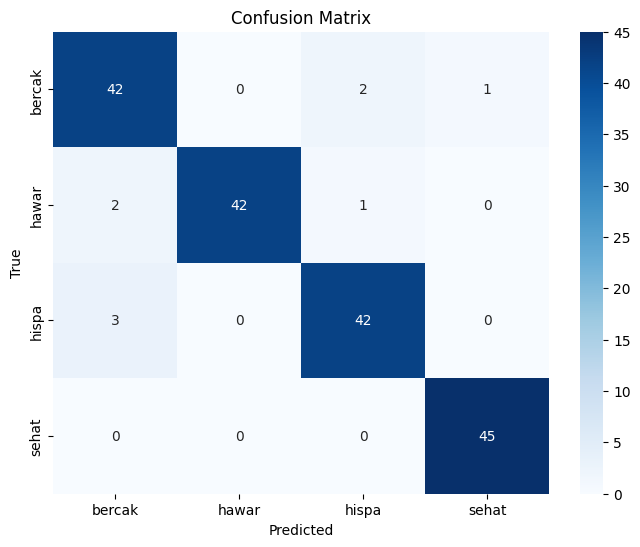

<Figure size 640x480 with 0 Axes>

In [29]:
evaluate_model(model, testloader, criterion, device)

In [ ]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

output_size = 4  
model = CNNpenyakitPadi(output_size)

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[layer_idx].block(input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"feature map: {activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[layer_idx].block(input_image)
    relu_activations = F.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"ReLU activation: {relu_activations}")

    plt.show()

def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx].block.conv2d  # Assuming bias is in Conv2d layer
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias: {bias}")
    plt.show()

def visualize_input_channels(input_image):
    channels = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(channels.shape[2])
    fig.suptitle('Input Image Channels Visualization')

    for i, ax in enumerate(axs):
        ax.imshow(channels[:, :, i], cmap='gray')  
        ax.axis('off')
        print(f"channel {i + 1}: {channels[:, :, i]}")

    plt.show()

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((6, 6)),  
    transforms.ToTensor()
])
input_image = transform(input_image).unsqueeze(0)

visualize_input_channels(input_image)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)

visualize_bias(model, 0)

In [ ]:
from PIL import Image

model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
model.eval()

activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU)):
        layer.register_forward_hook(get_activation(name))

img = Image.open('/kaggle/input/padi-data/test/bercak/IMG000000000013.jpg')
rgb_image = img.convert('RGB')
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    
for name in activation1:
    folder_path = os.path.join('custom_12', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            current_image = activation1[file][0, i].cpu().numpy()
            print(f"Shape of {file}-{i}: {current_image.shape}")
            
            fig, ax = plt.subplots(1, 1)
            ax.imshow(current_image)
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/penyakit-padi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False, batch_size=180)

feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
print(feature.shape)

In [ ]:
class_names = test_set.classes
for index, class_name in enumerate(class_names):
    print(f"name {class_name} label = {index}")

In [ ]:
for data_index, (sample, label) in enumerate(test_set):
    class_name = test_set.classes[label]
    print(f"Index: {data_index}, Class Name: {class_name}, Label: {label}")

In [ ]:
0.86695 +0.032092+ 0.051306+ 0.049649

In [ ]:

with torch.no_grad():
    model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
print(output)

In [ ]:
print(preds)

In [ ]:
x = np.arange(2,10,2)
y = x**2
pr

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(x,y)
axes[1].plot(y,x)